<a href="https://colab.research.google.com/github/hkws-lab/NMRstar_parser/blob/main/nmrstar_parser_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/hkws-lab/NMRstar_parser.git

Cloning into 'NMRstar_parser'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 7.86 KiB | 2.62 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
from NMRstar_parser.parser import *
import seaborn as sns
import matplotlib.pyplot as plt

# Here's unphosphorylated NtrCr from Volkman ... Kern 2001

# Parse the file
fetch_nmrstar_file(4527)  # saves as bmr4527_3.str
entry = parse_nmr_star('bmr4527_3.str')

# Extract Chem shift dataframe
cs = get_chem_shifts(entry)
cs

,index,Entity_ID,Seq_ID,Auth_seq_ID,Comp_ID,Atom_ID,Atom_type,Val,name,cs_saveframe_id
0,0,1,2,.,GLN,CA,C,55.70,.,chemical_shift_set_1
1,1,1,2,.,GLN,HA,H,4.52,.,chemical_shift_set_1
2,2,1,2,.,GLN,CB,C,30.00,.,chemical_shift_set_1
3,3,1,2,.,GLN,HB2,H,2.12,.,chemical_shift_set_1
4,4,1,2,.,GLN,HB3,H,2.03,.,chemical_shift_set_1
...,...,...,...,...,...,...,...,...,...,...
1339,1339,1,124,.,GLU,HB2,H,2.08,.,chemical_shift_set_1
1340,1340,1,124,.,GLU,HB3,H,1.94,.,chemical_shift_set_1
1341,1341,1,124,.,GLU,CG,C,36.80,.,chemical_shift_set_1
1342,1342,1,124,.,GLU,HG2,H,2.28,.,chemical_shift_set_1


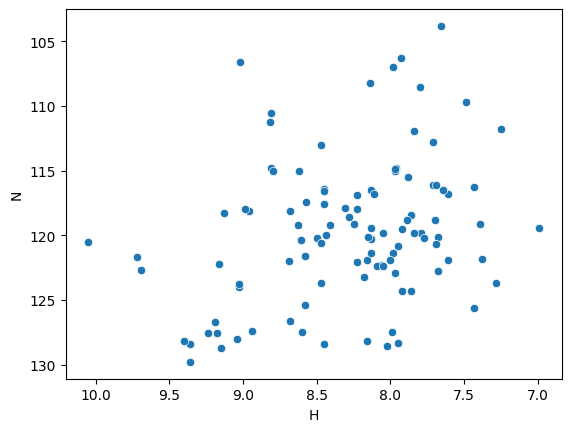

In [4]:

# I want make a CS dataframe with one row per residue,
# and simulate an HSQC of this protein.
# To do that I'll take the backbone N and H shifts.

pivoted = (
    cs[cs['Atom_ID'].isin(['N', 'H'])]
    .pivot_table(
        index=['Entity_ID', 'Seq_ID', 'Comp_ID'],
        columns='Atom_type',
        values='Val',
    )
    .reset_index()
)
pivoted.columns.name = None

sns.scatterplot(x='H',y='N',data=pivoted)

#inverting to put higher frequencies at top right
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [5]:
# here's a more complicated entry has four entities: two dna strands, hERR2 protein, and Zn atom. Entities help us keep track of them

fetch_nmrstar_file(5363)  # saves as bmr5363_3.str

# Parse the file
entry = parse_nmr_star('bmr5363_3.str')

# Extract useful information
entities = get_sequences(entry)
cs = get_chem_shifts(entry)

entities

,DNA_strand1,DNA_strand2,ZN,hERR2
ID,2,3,4,1
Polymer_type,polydeoxyribonucleotide,polydeoxyribonucleotide,.,polypeptide(L)
Polymer_seq_one_letter_code,GCTCAAGGTCACG,CGTGACCTTGAGC,.,AIPKRLCLVCGDIASGYHYGVASCEACKAFFKRTIQGNIEYSCPAT...


In [6]:
# At the moment cs dataframe contains all chem shifts, which is across the 2 DNA and protein entities.
# Note here each was saved in a different saveframe.
cs

,index,Entity_ID,Seq_ID,Auth_seq_ID,Comp_ID,Atom_ID,Atom_type,Val,name,cs_saveframe_id
0,0,1,1,97,ALA,CA,C,49.85,.,chemical_shifts_1
1,1,1,1,97,ALA,HA,H,4.11,.,chemical_shifts_1
2,2,1,1,97,ALA,CB,C,20.08,.,chemical_shifts_1
3,3,1,1,97,ALA,HB1,H,1.48,.,chemical_shifts_1
4,4,1,1,97,ALA,HB2,H,1.48,.,chemical_shifts_1
...,...,...,...,...,...,...,...,...,...,...
1271,89,3,13,26,DC,H6,H,7.37,.,chemical_shifts_3
1272,90,3,13,26,DC,H5,H,5.42,.,chemical_shifts_3
1273,91,3,13,26,DC,H3,H,4.42,.,chemical_shifts_3
1274,92,3,13,26,DC,H2,H,2.07,.,chemical_shifts_3


In [8]:
# I want to get only chemical shifts corresponding to the protein hERR2.
# I could look and see the hERR2 protein is entity_ID 1, or if I want to do this in a programmatic way:

polypeptide_entities = list(entities.loc['ID', entities.loc['Polymer_type'] == 'polypeptide(L)'])
pcs = cs.loc[cs.Entity_ID.isin(polypeptide_entities)]
pcs

,index,Entity_ID,Seq_ID,Auth_seq_ID,Comp_ID,Atom_ID,Atom_type,Val,name,cs_saveframe_id
0,0,1,1,97,ALA,CA,C,49.85,.,chemical_shifts_1
1,1,1,1,97,ALA,HA,H,4.11,.,chemical_shifts_1
2,2,1,1,97,ALA,CB,C,20.08,.,chemical_shifts_1
3,3,1,1,97,ALA,HB1,H,1.48,.,chemical_shifts_1
4,4,1,1,97,ALA,HB2,H,1.48,.,chemical_shifts_1
...,...,...,...,...,...,...,...,...,...,...
1085,1085,1,97,193,ASN,HB2,H,2.68,.,chemical_shifts_1
1086,1086,1,97,193,ASN,HB3,H,2.82,.,chemical_shifts_1
1087,1087,1,97,193,ASN,ND2,N,112.85,.,chemical_shifts_1
1088,1088,1,97,193,ASN,HD21,H,6.84,.,chemical_shifts_1
